# **É possivél utilizar modelos de machine learning que possam contribuir na descoberta de novos medicamentos?**

![drug_discover](https://user-images.githubusercontent.com/52214785/117590529-580b7c80-b106-11eb-91f0-1dcdb941f8ed.jpeg)


Para responder essa pergunta temos que navegar no mundo do **drug discover**. 
Vamos analisar um conjunto de dados que fornece diversas informações sobre compostos que foram testados em laboratórios, bem como os resultados obtidos para cada um dos experimentos.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()

In [ ]:
url_1 = 'https://github.com/fellypesb/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true'
url_2 = 'https://github.com/fellypesb/imersao-dados-desafio-final/blob/main/Dados/dados_resultados.csv?raw=true'
df_experimentos = pd.read_csv(url_1, compression='zip')
df_resultados = pd.read_csv(url_2)

# **Layout dos dados**
Em nossa base de dados cada linha corresponde a uma amostra dos dados ou informações acerca dos experimentos utilizados. E cada coluna corresponde a um atributo ou também conhecido como **feature**. Utilizando o pandas, para realizar a importação da base de dados, obtemos o tipo *pd.DataFrame()* que é um tipo de estrutura muito semelhante a do excel.

In [ ]:
df_experimentos.head() # Exibe as cinco primeiras linhas do conjunto de dados


,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


# **Identificando as Features**
As seguintes **features** fazem parte do nosso conjunto de dados, algumas delas são autoexplicativas:

**id** = identificação única de cada experimento/assinatura, possuem 23814 valores;    
**tratamento** = Tipo de tratamento utilizado nos experimentos. Podem ser de dois tipos: com_droga ou com_controle;  
**tempo** = Tempo de observação dos experimentos: 24, 48, 72;  
**dose** = referente a dosagem de cada composto aplicada nos experimentos. É possível encontrar duas: D1, D2;  
**droga** = Compostos utilizados nos experimentos. Possui 3289 compostos únicos;  
**genes** = g[0:771] e c[0:99]


In [ ]:
len(df_experimentos['id'].unique()) # Quantidade de valores unicos na coluna 'id'


23814

In [ ]:
df_experimentos['tratamento'].unique() # Quantidade de valores únicos na coluna 'tratamento'

array(['com_droga', 'com_controle'], dtype=object)

In [ ]:
df_experimentos['tempo'].unique() # Quantidade de valores únicos na coluna 'tempo'

array([24, 72, 48])

In [ ]:
df_experimentos['dose'].unique() # Quantidade de valores únicos na coluna 'dose'

array(['D1', 'D2'], dtype=object)

In [ ]:
len(df_experimentos['droga'].unique()) # Quantidade de compostos únicos na coluna 'droga'

3289

In [ ]:
pd.Series(df_experimentos.columns.str.contains('g-')).value_counts()[1] # quantidade de genes do tipo 'g'


772

In [ ]:
pd.Series(df_experimentos.columns.str.contains('c-')).value_counts()[1] # quantidade de genes do tipo 'c'

100

# **Investigando as features**

### Tratamento

Indentificou-se que havia alto desbalanceamento nas categorias da coluna tratamento, de forma que, a categoria `com_droga` representava cerca de **90%** dos experimentos. Investigando esse desproporção, descobriu-se que a categoria `com_droga` estava associada a diverssos compostos que foram testados, diferente da categoria `com_controle` que tinha o objetivo apenas de simular as células em seu comportamento normal (sem reação aos composto testados). Para todos os experimentos de tratamento `com_controle`, uma única droga foi aplicada, a **cacb2b860**. Já para o tratamento `com_droga`, foram testados **3288** compostos diferentes, possível razão do alto desbalanceamento desta coluna.   


In [ ]:
df_experimentos['tratamento'].value_counts()

com_droga       21948
com_controle     1866
Name: tratamento, dtype: int64

In [ ]:
df_experimentos['tratamento'].value_counts(normalize=True) # Proporção das categorias presentes na coluna tratamento

com_droga       0.921643
com_controle    0.078357
Name: tratamento, dtype: float64

In [ ]:
len(df_experimentos.query('tratamento == "com_droga"')['droga'].unique()) # quantidades de compostos experimentados

3288

In [ ]:
df_experimentos.query('tratamento == "com_controle"')['droga'].unique() # droga utilizada no tipo de tratamento com_controle

array(['cacb2b860'], dtype=object)

### Droga
Identificou-se que os 5 compostos mais utilizados nos experimentos foram:  

+ **87d714366** com frequência = 718
+ **9f80f3f77** com frequência = 246
+ **8b87a7a83** com frequência = 203
+ **5628cb3ee** com frequência = 202
+ **d08af5d4b** com frequência = 196




In [ ]:
c_droga = df_experimentos['droga'].value_counts().index[1:6] # Contagem dos 5 compostos mais utilizados excluido o composto utilizado no tratamento com_controle
c_droga

Index(['87d714366', '9f80f3f77', '8b87a7a83', '5628cb3ee', 'd08af5d4b'], dtype='object')

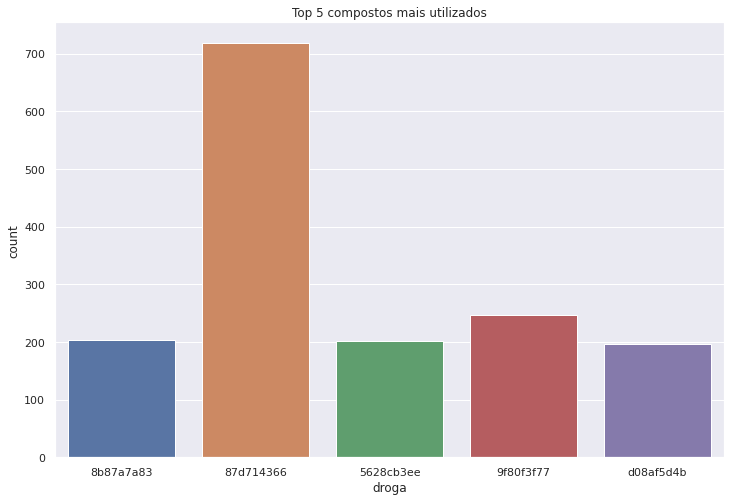

In [ ]:
plt.figure(figsize=(12,8))
ax =sns.countplot(x='droga', data=df_experimentos.query('droga in @c_droga')) 
ax.set_title('Top 5 compostos mais utilizados')
plt.show()

In [ ]:
df_experimentos.loc[:,'g-0':'g-771'].describe().T # Descrições estatísitcas dos genes tipo 'g'

,count,mean,std,min,25%,50%,75%,max
g-0,23814.0,0.248366,1.393399,-5.513,-0.473075,-0.00885,0.525700,10.000
g-1,23814.0,-0.095684,0.812363,-5.737,-0.562200,-0.04660,0.403075,5.039
g-2,23814.0,0.152253,1.035731,-9.104,-0.437750,0.07520,0.663925,8.257
g-3,23814.0,0.081971,0.950012,-5.998,-0.429575,0.00805,0.463400,10.000
g-4,23814.0,0.057347,1.032091,-6.369,-0.470925,-0.02690,0.465375,10.000
...,...,...,...,...,...,...,...,...
g-767,23814.0,-0.076251,1.115477,-10.000,-0.506200,0.00990,0.511175,6.317
g-768,23814.0,0.134162,0.951264,-4.269,-0.353100,0.00540,0.409075,10.000
g-769,23814.0,-0.128018,1.230636,-10.000,-0.544600,0.00060,0.498500,5.911
g-770,23814.0,-0.219210,1.326193,-10.000,-0.554400,0.02870,0.496400,10.000


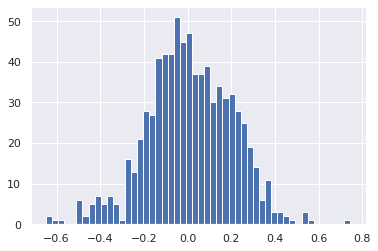

In [ ]:
df_experimentos.loc[:,'g-0':'g-771'].describe().T['mean'].hist(bins=50)
plt.show()

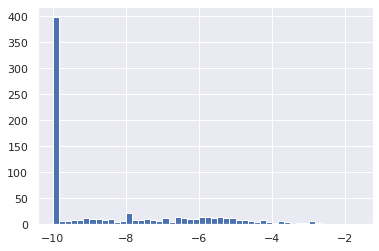

In [ ]:
df_experimentos.loc[:,'g-0':'g-771'].describe().T['min'].hist(bins=50)
plt.show()

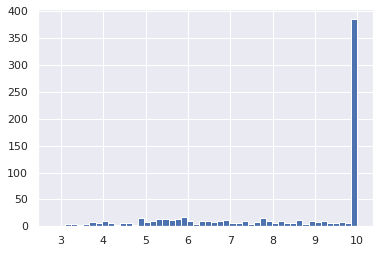

In [ ]:
df_experimentos.loc[:,'g-0':'g-771'].describe().T['max'].hist(bins=50)
plt.show()

Ao analizar o valores máximos e mínimos dos ... genes foi possível perceber que esses dados já estavam possivelmente normalizados entre 10 e -10. Isso descarta a necessidade de realizar este pré-processamento (normalização dos dados) antes de fornercer essas informações ao modelo. 

In [ ]:
df_experimentos.loc[:,'c-0':'c-99'].describe().T # Descrições estatísitcas dos genes tipo 'g'

,count,mean,std,min,25%,50%,75%,max
c-0,23814.0,-0.355156,1.752565,-10.0,-0.549300,-0.00900,0.448975,3.365
c-1,23814.0,-0.455359,2.004962,-10.0,-0.538425,0.00980,0.476875,3.915
c-2,23814.0,-0.480542,2.039346,-10.0,-0.550375,-0.00400,0.460575,2.970
c-3,23814.0,-0.377666,1.554583,-10.0,-0.601975,-0.03905,0.413100,2.408
c-4,23814.0,-0.493552,2.091888,-10.0,-0.559975,0.01140,0.470300,4.555
...,...,...,...,...,...,...,...,...
c-95,23814.0,-0.353726,1.629291,-10.0,-0.567975,-0.01025,0.444750,2.814
c-96,23814.0,-0.463485,2.059725,-10.0,-0.552575,-0.00125,0.465225,3.505
c-97,23814.0,-0.378241,1.703615,-10.0,-0.561000,-0.00680,0.446400,2.924
c-98,23814.0,-0.470252,1.834828,-10.0,-0.592600,0.01400,0.461275,3.111


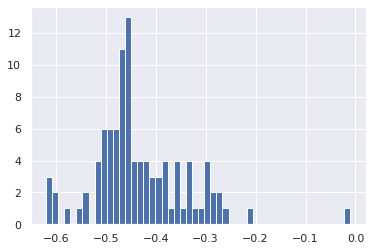

In [ ]:
df_experimentos.loc[:,'c-0':'c-99'].describe().T['mean'].hist(bins=50)
plt.show()

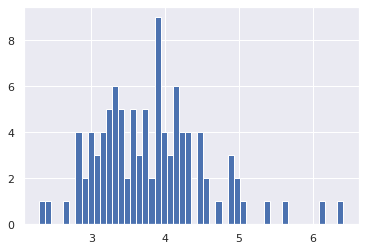

In [ ]:
df_experimentos.loc[:,'c-0':'c-99'].describe().T['max'].hist(bins=50)
plt.show()

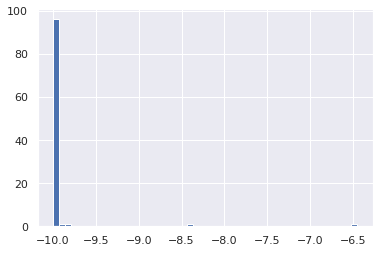

In [ ]:
df_experimentos.loc[:,'c-0':'c-99'].describe().T['min'].hist(bins=50)
plt.show()

# **Análises estatísticas**

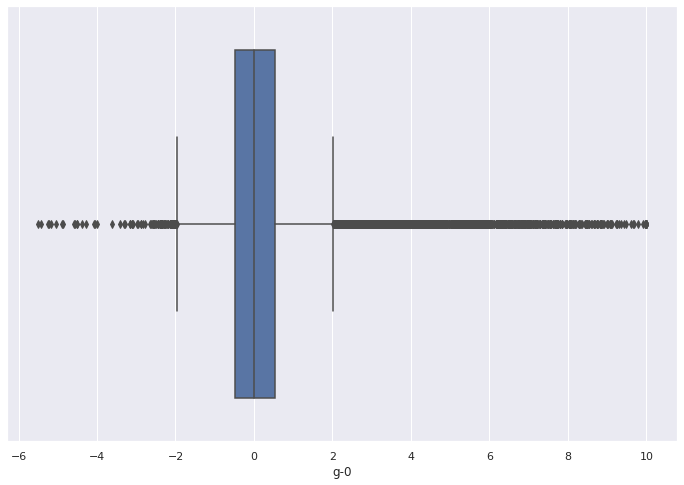

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df_experimentos, x='g-0')
plt.show()

In [ ]:
pd.crosstab([df_experimentos['dose'],df_experimentos['tempo']], df_experimentos['tratamento']) # Cruzamentos entre dados de dose, tempo e tratamento

tratamento  com_controle  com_droga
dose tempo                         
D1   24              301       3585
     48              343       4011
     72              307       3600
D2   24              305       3581
     48              305       3591
     72              305       3580

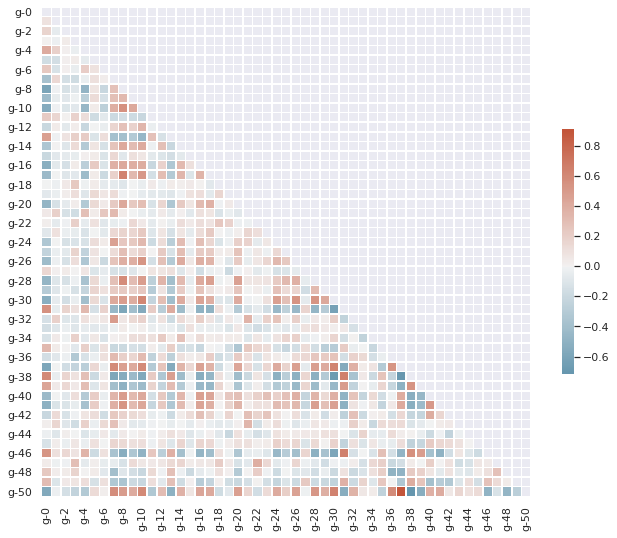

In [ ]:
corr_ = df_experimentos.loc[:,'g-0':'g-50'].corr()
mask = np.triu(np.ones_like(corr_, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# **Analisando os resultados dos experimentos**
Neste conjuntos de dados está presente os resultados obtidos para cada experimento. Cada coluna possui apenas dois valores: verdadeiro ou falso que indicam um determinado tipo de reação ou inibição ao composto testado nas células.

In [ ]:
df_resultados

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
c_moa = df_resultados.drop('id', axis=1).sum(axis=1) # Soma por linhas

In [ ]:
df_resultados['c_moa'] = c_moa
df_resultados

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,c_moa
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_resultados['moa_ativo'] = (df_resultados['c_moa'] != 0) 
df_resultados

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,c_moa,moa_ativo
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,True
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True


In [ ]:
df_merge = pd.merge(df_experimentos, df_resultados[['id', 'c_moa', 'moa_ativo']], on='id')

In [ ]:
df_merge

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,c_moa,moa_ativo
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,True
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,

In [ ]:
df_merge['moa_ativo'].value_counts() # Contagem dos experimentos que ativaram e não ativaram nenhum moa

True     14447
False     9367
Name: moa_ativo, dtype: int64

In [ ]:
df_merge.query('tratamento == "com_controle"')['moa_ativo'].value_counts()

False    1866
Name: moa_ativo, dtype: int64

In [ ]:
df_merge.query('tratamento == "com_droga"')['moa_ativo'].value_counts()

True     14447
False     7501
Name: moa_ativo, dtype: int64

Identificou-se que para todos os experimentos do tipo `com_controle` nenhum moa foi ativado.

# **Construção do modelo**

### Atributos previsores
Descartamos a coluna `id`, pois não nos fornece nenhuma informação relevante em relação aos experimentos. Descartamos também, todas as colunas que provocam vazamento de informações (leaky feature) como é o caso dos atributos `c_moa` e `moa_ativo`, isso porque esses atributos já contém informações a cerca do que queremos prever. 

Utilizamos como atributos previsores apenas aqueles que são representados por valores reais, isto é, os efeitos observados nos genes g e c. 

### Alvo das predições

E temos como alvo das previsões a quantidade de Moa's ativos para cada tipo de experimento.

In [ ]:
# Modelos sem variáveis dummies

X = df_merge.select_dtypes('float64')
y = df_merge['moa_ativo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

model_MLP = MLPClassifier(solver='sgd', learning_rate='adaptive', momentum=0.001, random_state=42)
model_MLP.fit(X_train, y_train)
model_MLP.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.6393029603191266

Como dito anteriormente as colunas `tratamento`, `dose` e `tempo` são atributos que possuem variáveis categóricas do tipo string (texto), essas categorias foram reestruturadas na forma de variáveis *dummies*. Agora é possivel encontrar colunas específicas para cada uma dessas categorias com somente dois valores discretos (0 ou 1) que indicam a presença ou não da categoria específica no experimento. Além disso, agora o modelo pode ter acesso a essas categorias possibilitando melhor abstração de informações da base de dados. Porém, após atualizar o modelo com as variáveis *dummies* (célula abaixo) verificou-se que a pontuação ainda estava bastante próxima do modelo anterior score = 0,62. 

In [ ]:
# Modelo com variáveis dummies

x = df_merge.drop(['id', 'c_moa', 'moa_ativo', 'droga'], axis=1)
x = pd.get_dummies(x, columns=['tratamento', 'dose','tempo'])
y = df_merge['moa_ativo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

model_MLP = MLPClassifier(hidden_layer_sizes=(12,2), solver='sgd', learning_rate='adaptive', random_state=42)
model_MLP.fit(X_train, y_train)
model_MLP.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.6426621876968297

In [ ]:
confusion_matrix(y_test, model_MLP.predict(X_test))

array([[ 568, 1305],
       [ 397, 2493]])

In [ ]:
x.shape # Dimmensão das variáveis preditoras (linhas, colunas)

(23814, 879)

Um ponto negativo que podemos observar é a grande quantidade atributos que o modelo está tendo acesso e tentando abstrair. Até aqui o modelo está recebendo 879 atributos. Com isso, surge a hipótese de que a grande quantidade de atributos esteja prejudicando o modelo na realização de suas predições. Pois, a medida que aumentamos o conjunto de variáveis preditoras aumentamos também a dimensionalidade e complexidade do modelo algo conhecido como a **"maldição da dimensionalidade"** [referencia]. Para contornar esse problema optou-se por selecionar apenas os atributos que mais contruibuem nas previsões do modelo e excluir os atributos que menos contribuem. Remover um atributo não significa que a pontuação cairá na mesma medida, pois outros atributos  poderão ser colineares[referencia].

In [ ]:
x = df_merge.drop(['id', 'c_moa', 'moa_ativo', 'droga'], axis=1)
x = pd.get_dummies(x, columns=['tratamento', 'dose','tempo'])
y = df_merge['moa_ativo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
model_rf.feature_importances_

# **Importâcia dos atributos**
Para analisar a importância de cada atributo utilizou-se o modelo *Random forest classifier* que já disponibiliza essa funcionalidade. Ao analisar a taxa de importância (célula acima), verificou-se a presença de valores **pequenos e próximos** para todos os atributos. Isso está possivelmente relacionado com a **alta cardinalidade** dos atributos (muitos valores exclusivos), e neste caso, as taxas de importâncias são baixas e imprecisas como relatado na documentação do [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). Com isso, o problema para selecionar apenas os atributos mais importantes não é possível ser solucionado com essa metodologia.



# **Otimização dos hiperparâmetros**

Outras possível forma de melhorar as predições de um modelo é alterando seus hiperâmetros em buscas dos melhores. Abaixo é realizado a otimização dos hiperparâmetros com o auxílio do algoritmo `Randomized Search`. Na célula abaixo os seguintes hiperparâmetros foram otimizados:

+ Número de neurônios na camada oculta
+ Função de ativação
+ Taxa de aprendizado
+ Taxa de aprendizado inicial
+ Constante de momento
+ Tamanho do lote
+ Alfa (constante de regularização)



In [ ]:
x = df_merge.drop(['id', 'c_moa', 'moa_ativo', 'droga'], axis=1)
x = pd.get_dummies(x, columns=['tratamento', 'dose','tempo'])
y = df_merge['moa_ativo'].replace({True:1, False:0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

parameters = {'hidden_layer_sizes':np.arange(2, 41, 2),
              'activation': ['logistic', 'tanh', 'relu'],
              'learning_rate': ['constant', 'adaptive', 'invscaling'],
              'learning_rate_init': np.logspace(-10, -0.2, base=2, num=15),
              'momentum': np.logspace(-10, -0.1, base=2, num=15),
              'batch_size': [8,16,32,64,128,256],
              'alpha': np.power(10, np.arange(-4, 0, dtype=float))}

model_MLP = MLPClassifier(max_iter=100, random_state=42, solver='sgd')
search = RandomizedSearchCV(model_MLP,
                            param_distributions=parameters,
                            n_iter=5,
                            n_jobs=-1,
                            error_score=np.NaN,
                            random_state=42)
search.fit(X_train, y_train)
search.score(X_test, y_test)

0.6552592903632165

In [69]:
search.best_params_

{'activation': 'logistic',
 'alpha': 0.1,
 'batch_size': 16,
 'hidden_layer_sizes': 8,
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.5358867312681471,
 'momentum': 0.04927989038222336}

Após realizar a otimização dos hiperparâmetros os resultados ainda foram pouco expressivos com baixa acurácia e próximo das acurácia de modelos mais simples. Porém, por conta do custo de processamento não foi aplicado uma otimização mais robusta, optou-se por utilizar um valor pequeno no parâmetro `n_iter` e por isso, os resultados não foram tão bons. 